In [31]:
import time
import pandas
import numpy as np
import tqdm
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.stats import kurtosis, pearsonr

from matplotlib import pyplot as plt
from numpy.linalg import norm

from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.feature_selection import SelectKBest as Kbest,chi2
from sklearn.random_projection import GaussianRandomProjection as RCA
from sklearn.preprocessing import StandardScaler as Std, MinMaxScaler as MinMax

from sklearn.model_selection import train_test_split,learning_curve
from sklearn.metrics import f1_score,precision_recall_curve,plot_confusion_matrix,precision_recall_fscore_support,accuracy_score

### Some preprocessing to remove rows with NANs and to turn strings into numerical values

In [2]:
DS1 = pandas.read_csv('liver_patient.csv', delimiter=',')
DS2 = pandas.read_csv('fall_detection.csv', delimiter=',')

In [3]:
DS1.loc[DS1['Gender']=='Male','Gender']=1
DS1.loc[DS1['Gender']=='Female','Gender']=0

In [4]:
DS1 = DS1.dropna()

### Class ratios for datasets:

In [5]:
DS1_arr = DS1.values
DS2_arr = DS2.values

X1,y1 = DS1_arr[:,:-1],DS1_arr[:,-1]
y1 -= 1
y1=y1.astype('int')

X2,y2 = DS2_arr[:,1:],DS2_arr[:,0]
y2=y2.astype('int')

scaler = Std()
X1 = scaler.fit_transform(X1)
scaler = Std()
X2 = scaler.fit_transform(X2)

scaler = MinMax()
X1_pos = scaler.fit_transform(X1)
scaler = MinMax()
X2_pos = scaler.fit_transform(X2)

In [6]:
counts, unique = np.unique(y1, return_counts=1)
print('labals ratios for Dataset 1', unique/np.sum(unique))

labals ratios for Dataset 1 [0.71502591 0.28497409]


In [7]:
counts, unique = np.unique(y2, return_counts=1)
print('labals ratios for Dataset 1', unique/np.sum(unique))

labals ratios for Dataset 1 [0.28128434 0.03064339 0.1527286  0.21902088 0.21328287 0.10303992]


# TSNE plotting of the datasets

In [8]:
def plot_2D(X,labels,name):
    TSNE_ = TSNE(random_state=0)
    tsne1 = TSNE_.fit_transform(X)
    plt.figure()
    plt.scatter(tsne1[:,0],tsne1[:,1],c =labels, cmap='inferno', marker='.')
    plt.title('2D vis of %s'%name)
    plt.show()

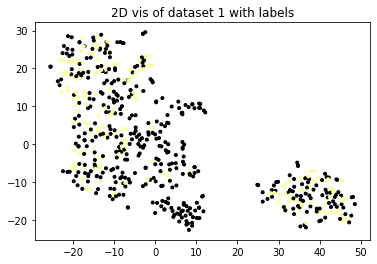

In [43]:
plot_2D(X1,y1,'dataset 1 with labels')

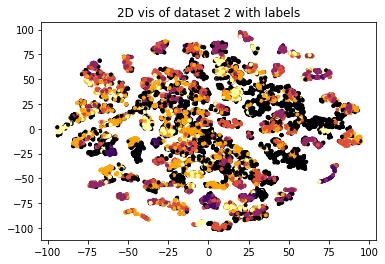

In [11]:
plot_2D(X2,y2,'dataset 2 with labels')

# Clustering with K-means

In [12]:
km1 = KMeans(n_clusters=2,tol=1e-5)
km2 = KMeans(n_clusters=6)

GM1 = GaussianMixture(n_components=2,tol=1e-5)
GM2 = GaussianMixture(n_components=6)

km1_clusters = km1.fit_predict(X1)
km2_clusters = km2.fit_predict(X2)

GM1_clusters = GM1.fit_predict(X1)
GM2_clusters = GM2.fit_predict(X2)

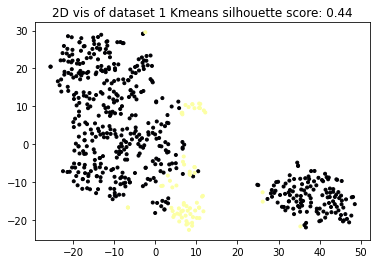

In [13]:
plot_2D(X1,km1_clusters,'dataset 1 Kmeans silhouette score: {0:.2f}'.format(silhouette_score(X1,km1.labels_)))

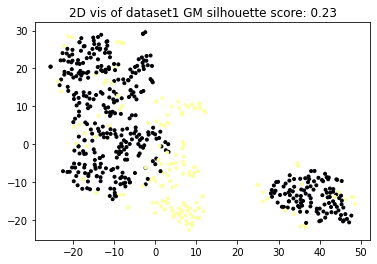

In [14]:
plot_2D(X1,GM1_clusters,'dataset1 GM silhouette score: {0:.2f}'.format(silhouette_score(X1,GM1_clusters)))

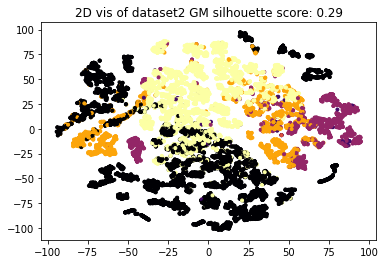

In [15]:
plot_2D(X2,GM2_clusters,'dataset2 GM silhouette score: {0:.2f}'.format(silhouette_score(X2,GM2_clusters)))

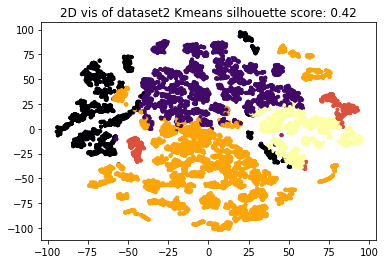

In [16]:
plot_2D(X2,km2_clusters,'dataset2 Kmeans silhouette score: {0:.2f}'.format(silhouette_score(X2,km2.labels_)))

In [17]:
K_means1_ssd = []
K_means2_ssd = []

K_means1_sil = []
K_means2_sil = []

for k in range(1,12):
    km1 = KMeans(n_clusters=k)
    km2 = KMeans(n_clusters=k)

    km1.fit(X1)
    km2.fit(X2)
    
    K_means1_ssd.append(km1.inertia_)
    K_means2_ssd.append(km2.inertia_)
    
    if k != 1:
        K_means1_sil.append(silhouette_score(X1,km1.labels_))
        K_means2_sil.append(silhouette_score(X2,km2.labels_))

In [60]:
def GM_SSD(gm,X):
    
    #function to compute sum of square distances for gaussian mixture
    
    y = gm.fit_predict(X)
    SSD = 0
    n_ex = X.shape[0]
    #n_clust, n_ft = gm.means_.shape
    for i in range(n_ex):
        SSD += norm(X[i]- gm.means_[y[i]])
    
    return SSD
        

In [19]:
GM1_ssd = []
GM2_ssd = []

GM1_sil = []
GM2_sil = []

for k in range(1,12):
    GM1 = GaussianMixture(n_components=k, tol=1e-5)
    GM2 = GaussianMixture(n_components=k)

    GM1.fit_predict(X1)
    GM2.fit_predict(X2)
    
    GM1_ssd.append(GM_SSD(GM1,X1))
    GM2_ssd.append(GM_SSD(GM2,X2))
    
    if k != 1:
        GM1_sil.append(silhouette_score(X1,GM1.predict(X1)))
        GM2_sil.append(silhouette_score(X2,GM2.predict(X2)))

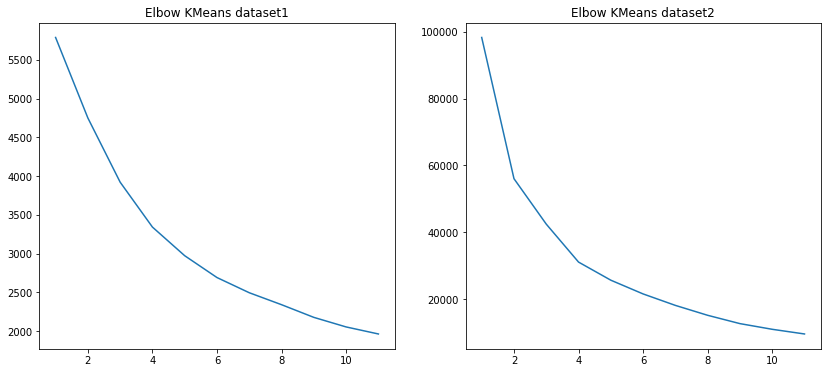

In [20]:
list_k = [i for i in range(1,12)]
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].set_title("Elbow KMeans dataset1")
ax[0].plot(list_k, K_means1_ssd)
ax[1].set_title("Elbow KMeans dataset2")
ax[1].plot(list_k, K_means2_ssd)
plt.show()

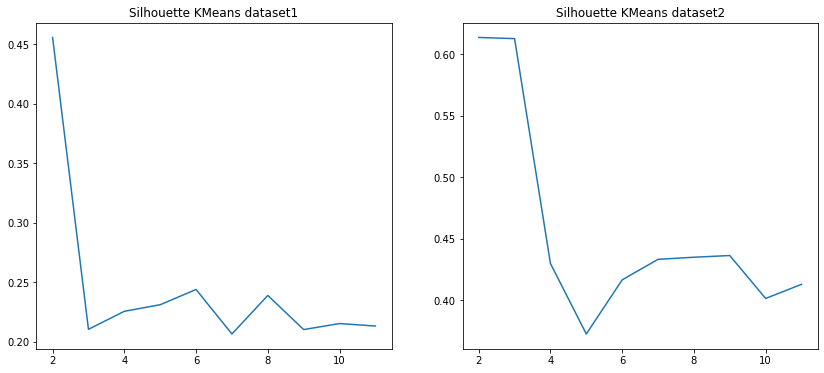

In [21]:
list_k = [i for i in range(2,12)]
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].set_title("Silhouette KMeans dataset1")
ax[0].plot(list_k, K_means1_sil)
ax[1].set_title("Silhouette KMeans dataset2")
ax[1].plot(list_k, K_means2_sil)
plt.show()

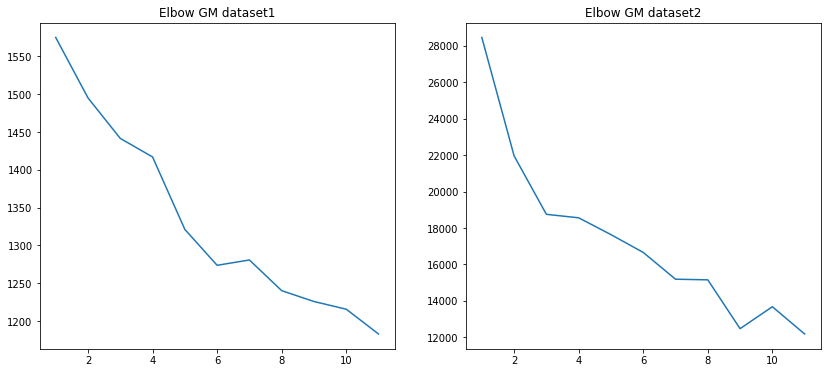

In [22]:
list_k = [i for i in range(1,12)]
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].set_title("Elbow GM dataset1")
ax[0].plot(list_k, GM1_ssd)
ax[1].set_title("Elbow GM dataset2")
ax[1].plot(list_k, GM2_ssd)
plt.show()

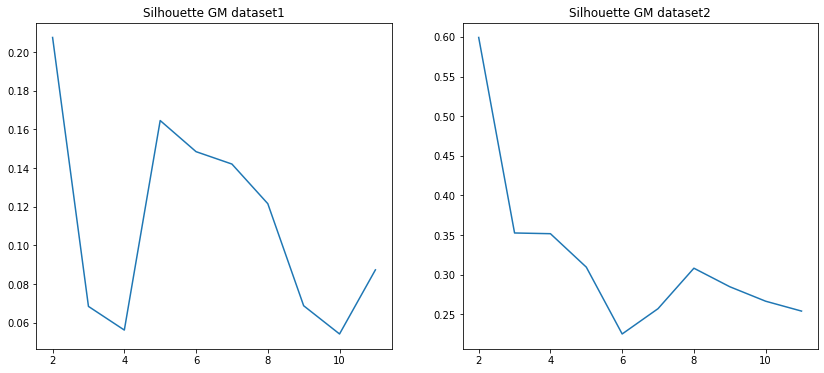

In [23]:
list_k = [i for i in range(2,12)]
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].set_title("Silhouette GM dataset1")
ax[0].plot(list_k, GM1_sil)
ax[1].set_title("Silhouette GM dataset2")
ax[1].plot(list_k, GM2_sil)
plt.show()

# Dimensionality reduction with feature projection

## PCA

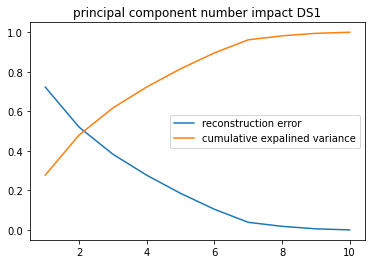

In [24]:
loss_pca1 = []

for k in range(1,X1.shape[1]+1):
    pca1 = PCA(k)
    pca1_x1 = pca1.fit_transform(X1)
    recons_pca1 = pca1.inverse_transform(pca1_x1)
    error = ((recons_pca1 - X1) ** 2).mean()
    loss_pca1.append(error)
    if k == X1.shape[1]:
        pca1_exp_var = np.cumsum(pca1.explained_variance_ratio_)

fig = plt.figure()
plt.title('principal component number impact DS1')
plt.plot(range(1,X1.shape[1]+1),loss_pca1,label='reconstruction error')
plt.plot(range(1,X1.shape[1]+1),np.cumsum(pca1.explained_variance_ratio_),label='cumulative expalined variance')
plt.legend()
plt.show()

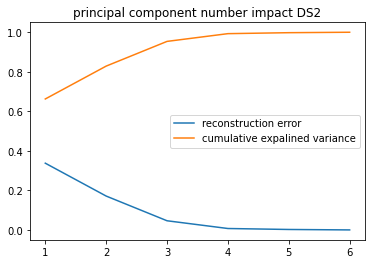

In [25]:
loss_pca2 = []

for k in range(1,X2.shape[1]+1):
    pca2 = PCA(k)
    pca2_x2 = pca2.fit_transform(X2)
    recons_pca2 = pca2.inverse_transform(pca2_x2)
    error = ((recons_pca2 - X2) ** 2).mean()
    loss_pca2.append(error)
    if k == X2.shape[1]:
        pca2_exp_var = np.cumsum(pca2.explained_variance_ratio_)

fig = plt.figure()
plt.title('principal component number impact DS2')
plt.plot(range(1,X2.shape[1]+1),loss_pca2,label='reconstruction error')
plt.plot(range(1,X2.shape[1]+1),np.cumsum(pca2.explained_variance_ratio_),label='cumulative expalined variance')
plt.legend()
plt.show()

In [55]:
pca1 = PCA(6)
pca_proj1 = pca1.fit_transform(X1)
pca2 = PCA(3)
pca_proj2 = pca2.fit_transform(X2)

## Fast ICA (maximization of kurtosis)

/home/aymane/.local/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


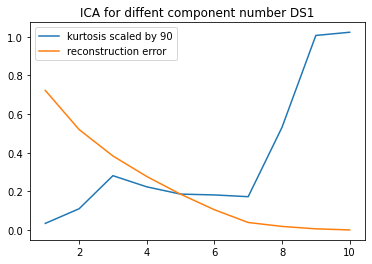

In [27]:
kurts = []
errs = []
for k in range(1,X1.shape[1]+1):
    ica1 = ICA(n_components=k, max_iter=3000,random_state=0)
    ica_X1 = ica1.fit_transform(X1)
    ku = kurtosis(ica_X1,axis=0)
    kurts.append(np.abs(ku).mean()/90)
    recons_ica1 = ica1.inverse_transform(ica_X1)
    errs.append(((recons_ica1 - X1) ** 2).mean())
    
fig = plt.figure()
plt.title('ICA for diffent component number DS1')
plt.plot(range(1,X1.shape[1]+1),kurts,label='kurtosis scaled by 90')
plt.plot(range(1,X1.shape[1]+1),errs,label='reconstruction error')
plt.legend()
plt.show()

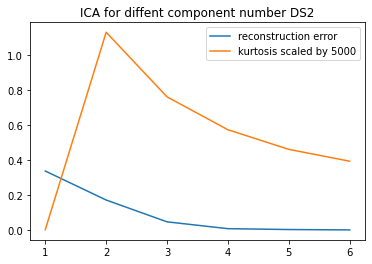

In [28]:
kurts = []
errs = []
for k in range(1,X2.shape[1]+1):
    ica2 = ICA(n_components=k, max_iter=3000,random_state=0)
    ica_X2 = ica2.fit_transform(X2)
    ku = kurtosis(ica_X2,axis=0)
    kurts.append(ku.mean()/5000)
    recons_ica2 = ica2.inverse_transform(ica_X2)
    errs.append(((recons_ica2 - X2) ** 2).mean())
    
fig = plt.figure()
plt.title('ICA for diffent component number DS2')
plt.plot(range(1,X2.shape[1]+1),errs,label='reconstruction error')
plt.plot(range(1,X2.shape[1]+1),kurts,label='kurtosis scaled by 5000')
plt.legend()
plt.show()

In [54]:
ica1 = ICA(9)
ica_proj1 = ica1.fit_transform(X1)
ica2 = ICA(3)
ica_proj2 = ica2.fit_transform(X2)

/home/aymane/.local/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


# Random projections

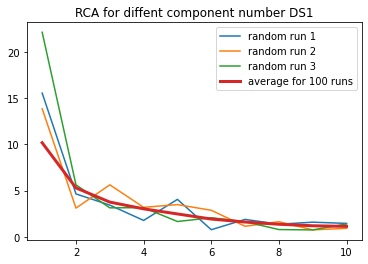

In [46]:
errs = []
randi = [[],[],[]]

for k in range(1,X1.shape[1]+1):
    randerr = []
    for n_rand in range(100):
        rpa1 = RCA(n_components=k)
        rpa_X1 = rpa1.fit_transform(X1)
        recons_rpa1 = np.dot(rpa_X1, rpa1.components_)  
        randerr.append(np.mean((X1 - recons_rpa1)**2))
    randi[0].append(randerr[0])
    randi[1].append(randerr[1])
    randi[2].append(randerr[2])
    errs.append(np.mean(randerr))

plt.figure()
plt.title('RCA for diffent component number DS1')
plt.plot(range(1,X1.shape[1]+1),randi[0], label='random run 1')
plt.plot(range(1,X1.shape[1]+1),randi[1], label='random run 2')
plt.plot(range(1,X1.shape[1]+1),randi[2], label='random run 3')
plt.plot(range(1,X1.shape[1]+1),errs, label='average for 100 runs', linewidth=3)
plt.legend()
plt.show()      


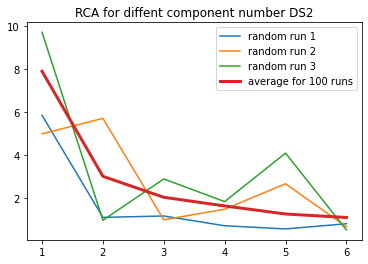

In [49]:
errs = []
randi = [[],[],[]]

for k in range(1,X2.shape[1]+1):
    randerr = []
    for n_rand in range(100):
        rca2 = RCA(n_components=k)
        rca_X2 = rca2.fit_transform(X2)
        recons_rca2 = np.dot(rca_X2, rca2.components_)  
        randerr.append(np.mean((X2 - recons_rca2)**2)) 
    randi[0].append(randerr[0])
    randi[1].append(randerr[1])
    randi[2].append(randerr[2])
    errs.append(np.mean(randerr))
plt.figure()
plt.title('RCA for diffent component number DS2')
plt.plot(range(1,X2.shape[1]+1),randi[0], label='random run 1')
plt.plot(range(1,X2.shape[1]+1),randi[1], label='random run 2')
plt.plot(range(1,X2.shape[1]+1),randi[2], label='random run 3')
plt.plot(range(1,X2.shape[1]+1),errs, label='average for 100 runs', linewidth=3)
plt.legend()
plt.show()      


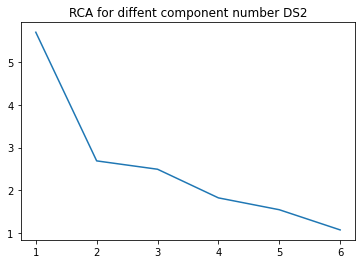

In [64]:
errs = []
randi = [[],[],[]]

for k in range(1,X2.shape[1]+1):
    randerr = []
    for n_rand in range(100):
        rca2 = RCA(n_components=k)
        rca_X2 = rca2.fit_transform(X2)
        recons_rca2 = np.dot(rca_X2, rca2.components_)  
        randerr.append(np.mean((X2 - recons_rca2)**2)) 
    randi[0].append(randerr[0])
    randi[1].append(randerr[1])
    randi[2].append(randerr[2])
    errs.append(np.mean(randerr))
plt.figure()
plt.title('RCA for diffent component number DS2')
plt.plot(range(1,X2.shape[1]+1),randi[0], label='random run 1')
plt.plot(range(1,X2.shape[1]+1),randi[1], label='random run 2')
plt.plot(range(1,X2.shape[1]+1),randi[2], label='random run 3')
plt.plot(range(1,X2.shape[1]+1),errs, label='average for 100 runs', linewidth=3)
plt.legend()
plt.show()      


In [53]:
rca1 = RCA(n_components=6)
rca_proj1 = rpa1.fit_transform(X1)
rca2 = RCA(n_components=4)
rca_proj2 = rca2.fit_transform(X2)

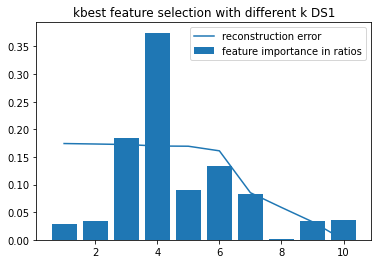

In [33]:
err_kbest1 = []

for k in range(1,X1.shape[1]+1):
    kbest1 = Kbest(chi2,k=k)
    kbest1_x1 = kbest1.fit_transform(X1_pos,y1)
    recons_kbest1 = kbest1.inverse_transform(kbest1_x1)
    error = ((recons_kbest1 - X1_pos) ** 2).mean()
    err_kbest1.append(error)

scores1 = kbest1.scores_/np.sum(kbest1.scores_)

fig = plt.figure()
plt.title('kbest feature selection with different k DS1')
plt.plot(range(1,X1.shape[1]+1),err_kbest1,label='reconstruction error')
plt.bar(range(1,X1.shape[1]+1),scores1,label='feature importance in ratios')
plt.legend()
plt.show()

In [34]:
scores1 = -scores1
scores1.sort()
scores1 = -scores1
scores1.cumsum()

array([0.37477951, 0.55886198, 0.69312854, 0.78394736, 0.86741079,
       0.9031761 , 0.93729472, 0.9705966 , 0.99891569, 1.        ])

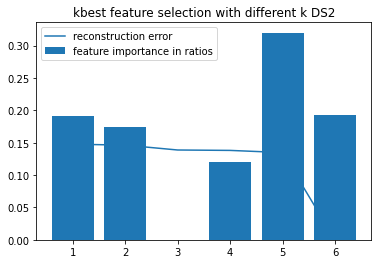

In [35]:
err_kbest2 = []

for k in range(1,X2.shape[1]+1):
    kbest2 = Kbest(chi2,k=k)
    kbest2_x2 = kbest2.fit_transform(X2_pos,y2)
    recons_kbest2 = kbest2.inverse_transform(kbest2_x2)
    error = ((recons_kbest2 - X2_pos) ** 2).mean()
    err_kbest2.append(error)

scores2 = kbest2.scores_/np.sum(kbest2.scores_)

fig = plt.figure()
plt.title('kbest feature selection with different k DS2')
plt.plot(range(1,X2.shape[1]+1),err_kbest2,label='reconstruction error')
plt.bar(range(1,X2.shape[1]+1),scores2,label='feature importance in ratios')
plt.legend()
plt.show()

In [36]:
scores2 = -scores2
scores2.sort()
scores2 = -scores2
scores2.cumsum()

array([0.31992593, 0.51327785, 0.70454499, 0.87927825, 0.99999668,
       1.        ])

In [51]:
kbest1 = Kbest(chi2,k=5)
kbest_proj1 = kbest1.fit_transform(X1_pos,y1)
kbest2 = Kbest(chi2,k=5)
kbest_proj2 = kbest2.fit_transform(X2_pos,y2)

## Dim red before clustering

### pca+kmeans

In [61]:
K_means1_ssd_pca = []
K_means2_ssd_pca = []

K_means1_sil_pca = []
K_means2_sil_pca = []

for k in range(1,12):
    km1 = KMeans(n_clusters=k)
    km2 = KMeans(n_clusters=k)

    km1.fit(pca_proj1)
    km2.fit(pca_proj2)
    
    if k==2:
        km_labels1 = km1.labels_
    if k==6:
        km_labels2 = km2.labels_
        
    K_means1_ssd_pca.append(km1.inertia_)
    K_means2_ssd_pca.append(km2.inertia_)
    
    if k != 1:
        K_means1_sil_pca.append(silhouette_score(pca_proj1,km1.labels_))
        K_means2_sil_pca.append(silhouette_score(pca_proj2,km2.labels_))
        
GM1_ssd_pca = []
GM2_ssd_pca = []

GM1_sil_pca = []
GM2_sil_pca = []

for k in range(1,12):
    GM1 = GaussianMixture(n_components=k, tol=1e-5)
    GM2 = GaussianMixture(n_components=k)

    GM1.fit_predict(pca_proj1)
    GM2.fit_predict(pca_proj2)
    
    if k==2:
        gm_labels1 = GM1.predict(pca_proj1)
    if k==6:
        gm_labels2 = GM2.predict(pca_proj2)
    
    GM1_ssd_pca.append(GM_SSD(GM1,pca_proj1))
    GM2_ssd_pca.append(GM_SSD(GM2,pca_proj2))
    
    if k != 1:
        GM1_sil_pca.append(silhouette_score(pca_proj1,GM1.predict(pca_proj1)))
        GM2_sil_pca.append(silhouette_score(pca_proj2,GM2.predict(pca_proj2)))

/home/aymane/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [62]:
def plot_ft_2D(X1,X2,k_labels,Em_labels,name):
    
    fig, ax = plt.subplots(2, 2, figsize=(12,8))
    
    TSNE_ = TSNE(random_state=0)
    tsne1 = TSNE_.fit_transform(X1)
    labels = k_labels[0]
    
    ax[0,0].scatter(tsne1[:,0],tsne1[:,1],c =labels, cmap='inferno', marker='.')
    ax[0,0].set_title( name+' + kmeans DS1')
    
    TSNE_ = TSNE(random_state=0)
    tsne1 = TSNE_.fit_transform(X2)
    labels = k_labels[1]
    
    ax[0,1].scatter(tsne1[:,0],tsne1[:,1],c =labels, cmap='inferno', marker='.')
    ax[0,1].set_title( name+' + kmeans DS2')
    
    TSNE_ = TSNE(random_state=0)
    tsne1 = TSNE_.fit_transform(X1)
    labels = Em_labels[0]
    
    ax[1,0].scatter(tsne1[:,0],tsne1[:,1],c =labels, cmap='inferno', marker='.')
    ax[1,0].set_title( name+' + GM DS1')
    
    TSNE_ = TSNE(random_state=0)
    tsne1 = TSNE_.fit_transform(X2)
    labels = Em_labels[1]
    
    ax[1,1].scatter(tsne1[:,0],tsne1[:,1],c =labels, cmap='inferno', marker='.')
    ax[1,1].set_title( name+' + GM DS2')
    
    plt.show()

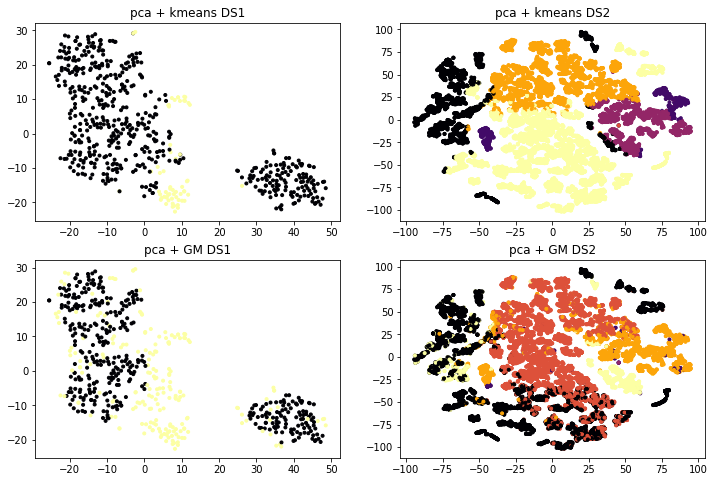

In [63]:
plot_ft_2D(X1,X2,[km_labels1,km_labels2],[gm_labels1,gm_labels2],'pca')

In [64]:
K_means1_ssd_ica = []
K_means2_ssd_ica = []

K_means1_sil_ica = []
K_means2_sil_ica = []

for k in range(1,12):
    km1 = KMeans(n_clusters=k)
    km2 = KMeans(n_clusters=k)

    km1.fit(ica_proj1)
    km2.fit(ica_proj2)
    
    if k==2:
        km_labels1 = km1.labels_
    if k==6:
        km_labels2 = km2.labels_
        
    K_means1_ssd_ica.append(km1.inertia_)
    K_means2_ssd_ica.append(km2.inertia_)
    
    if k != 1:
        K_means1_sil_ica.append(silhouette_score(ica_proj1,km1.labels_))
        K_means2_sil_ica.append(silhouette_score(ica_proj2,km2.labels_))
        
GM1_ssd_ica = []
GM2_ssd_ica = []

GM1_sil_ica = []
GM2_sil_ica = []

for k in range(1,12):
    GM1 = GaussianMixture(n_components=k, tol=1e-5)
    GM2 = GaussianMixture(n_components=k)

    GM1.fit_predict(ica_proj1)
    GM2.fit_predict(ica_proj2)
    
    if k==2:
        gm_labels1 = GM1.predict(ica_proj1)
    if k==6:
        gm_labels2 = GM2.predict(ica_proj2)
    
    GM1_ssd_ica.append(GM_SSD(GM1,ica_proj1))
    GM2_ssd_ica.append(GM_SSD(GM2,ica_proj2))
    
    if k != 1:
        GM1_sil_ica.append(silhouette_score(ica_proj1,GM1.predict(ica_proj1)))
        GM2_sil_ica.append(silhouette_score(ica_proj2,GM2.predict(ica_proj2)))

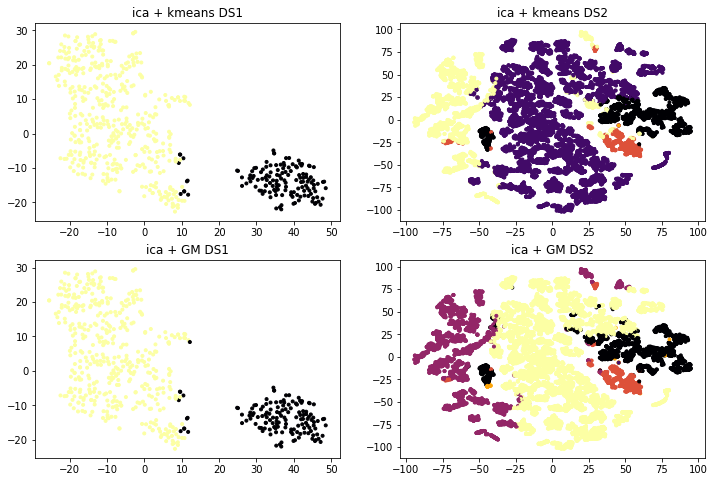

In [65]:
plot_ft_2D(X1,X2,[km_labels1,km_labels2],[gm_labels1,gm_labels2],'ica')

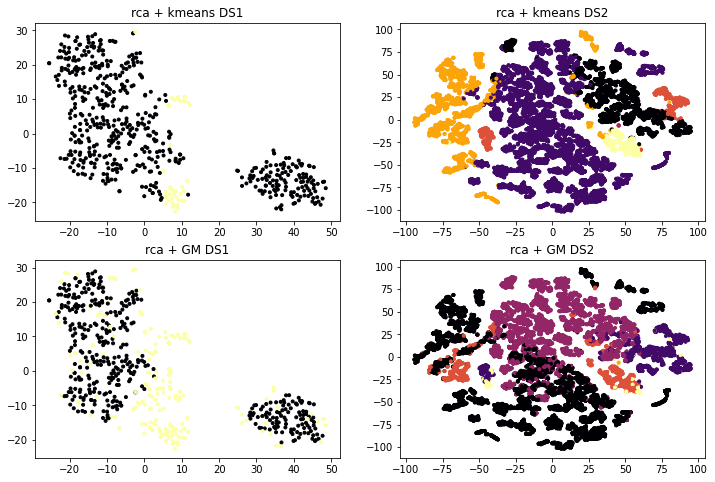

In [69]:
K_means1_ssd_rca = []
K_means2_ssd_rca = []

K_means1_sil_rca = []
K_means2_sil_rca = []

for k in range(1,12):
    km1 = KMeans(n_clusters=k)
    km2 = KMeans(n_clusters=k)

    km1.fit(rca_proj1)
    km2.fit(rca_proj2)
    
    if k==2:
        km_labels1 = km1.labels_
    if k==6:
        km_labels2 = km2.labels_
        
    K_means1_ssd_rca.append(km1.inertia_)
    K_means2_ssd_rca.append(km2.inertia_)
    
    if k != 1:
        K_means1_sil_rca.append(silhouette_score(rca_proj1,km1.labels_))
        K_means2_sil_rca.append(silhouette_score(rca_proj2,km2.labels_))
        
GM1_ssd_rca = []
GM2_ssd_rca = []

GM1_sil_rca = []
GM2_sil_rca = []

for k in range(1,12):
    GM1 = GaussianMixture(n_components=k, tol=1e-5)
    GM2 = GaussianMixture(n_components=k)

    GM1.fit_predict(rca_proj1)
    GM2.fit_predict(rca_proj2)
    
    if k==2:
        gm_labels1 = GM1.predict(rca_proj1)
    if k==6:
        gm_labels2 = GM2.predict(rca_proj2)
    
    GM1_ssd_rca.append(GM_SSD(GM1,rca_proj1))
    GM2_ssd_rca.append(GM_SSD(GM2,rca_proj2))
    
    if k != 1:
        GM1_sil_rca.append(silhouette_score(rca_proj1,GM1.predict(rca_proj1)))
        GM2_sil_rca.append(silhouette_score(rca_proj2,GM2.predict(rca_proj2)))
        
plot_ft_2D(X1,X2,[km_labels1,km_labels2],[gm_labels1,gm_labels2],'rca')

/home/aymane/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/aymane/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 

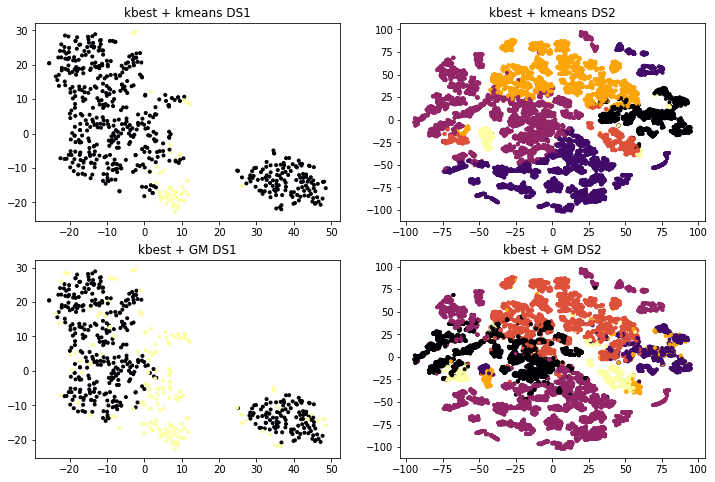

In [67]:
K_means1_ssd_kbest = []
K_means2_ssd_kbest = []

K_means1_sil_kbest = []
K_means2_sil_kbest = []

for k in range(1,12):
    km1 = KMeans(n_clusters=k)
    km2 = KMeans(n_clusters=k)

    km1.fit(kbest_proj1)
    km2.fit(kbest_proj2)
    
    if k==2:
        km_labels1 = km1.labels_
    if k==6:
        km_labels2 = km2.labels_
        
    K_means1_ssd_kbest.append(km1.inertia_)
    K_means2_ssd_kbest.append(km2.inertia_)
    
    if k != 1:
        K_means1_sil_kbest.append(silhouette_score(kbest_proj1,km1.labels_))
        K_means2_sil_kbest.append(silhouette_score(kbest_proj2,km2.labels_))
        
GM1_ssd_kbest = []
GM2_ssd_kbest = []

GM1_sil_kbest = []
GM2_sil_kbest = []

for k in range(1,12):
    GM1 = GaussianMixture(n_components=k, tol=1e-5)
    GM2 = GaussianMixture(n_components=k)

    GM1.fit_predict(kbest_proj1)
    GM2.fit_predict(kbest_proj2)
    
    if k==2:
        gm_labels1 = GM1.predict(kbest_proj1)
    if k==6:
        gm_labels2 = GM2.predict(kbest_proj2)
    
    GM1_ssd_kbest.append(GM_SSD(GM1,kbest_proj1))
    GM2_ssd_kbest.append(GM_SSD(GM2,kbest_proj2))
    
    if k != 1:
        GM1_sil_kbest.append(silhouette_score(kbest_proj1,GM1.predict(kbest_proj1)))
        GM2_sil_kbest.append(silhouette_score(kbest_proj2,GM2.predict(kbest_proj2)))
        
plot_ft_2D(X1,X2,[km_labels1,km_labels2],[gm_labels1,gm_labels2],'kbest')

In [80]:
np.max(K_means1_ssd_pca)

5184.654834775512

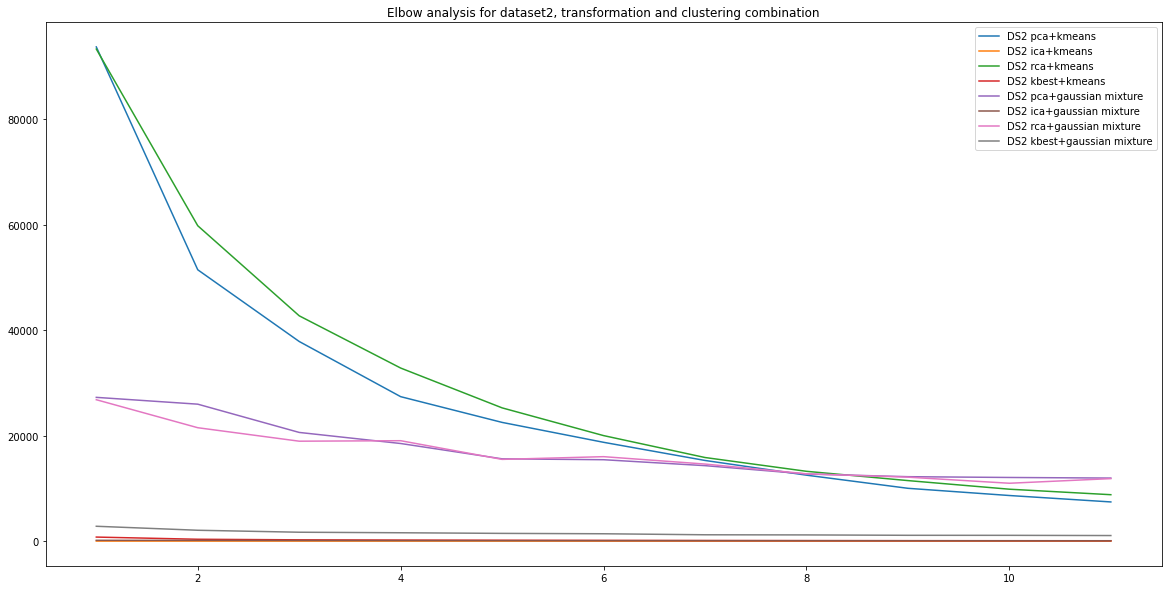

In [83]:
fig = plt.figure(figsize=(20,10))

plt.title('Elbow analysis for dataset2, transformation and clustering combination')
#plt.plot(range(1,12),np.array(K_means1_ssd_pca)/np.max(K_means1_ssd_pca),label='DS1 pca+kmeans')
plt.plot(range(1,12),np.array(K_means2_ssd_pca),label='DS2 pca+kmeans')

#plt.plot(range(1,12),np.array(K_means1_ssd_ica)/np.max(K_means1_ssd_ica),label='DS1 ica+kmeans')
plt.plot(range(1,12),np.array(K_means2_ssd_ica),label='DS2 ica+kmeans')

#plt.plot(range(1,12),np.array(K_means1_ssd_rca)/np.max(K_means1_ssd_rca),label='DS1 rca+kmeans')
plt.plot(range(1,12),np.array(K_means2_ssd_rca),label='DS2 rca+kmeans')

#plt.plot(range(1,12),np.array(K_means1_ssd_kbest)/np.max(K_means1_ssd_kbest),label='DS1 kbest+kmeans')
plt.plot(range(1,12),np.array(K_means2_ssd_kbest),label='DS2 kbest+kmeans')

#plt.plot(range(1,12),np.array(GM1_ssd_pca)/np.max(GM1_ssd_pca),label='DS1 pca+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_pca),label='DS2 pca+gaussian mixture')

#plt.plot(range(1,12),np.array(GM1_ssd_ica)/np.max(GM1_ssd_ica),label='DS1 ica+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_ica),label='DS2 ica+gaussian mixture')

#plt.plot(range(1,12),np.array(GM1_ssd_rca)/np.max(GM1_ssd_rca),label='DS1 rca+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_rca),label='DS2 rca+gaussian mixture')

#plt.plot(range(1,12),np.array(GM1_ssd_kbest)/np.max(GM1_ssd_kbest),label='DS1 kbest+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_kbest),label='DS2 kbest+gaussian mixture')

plt.legend()
plt.show()

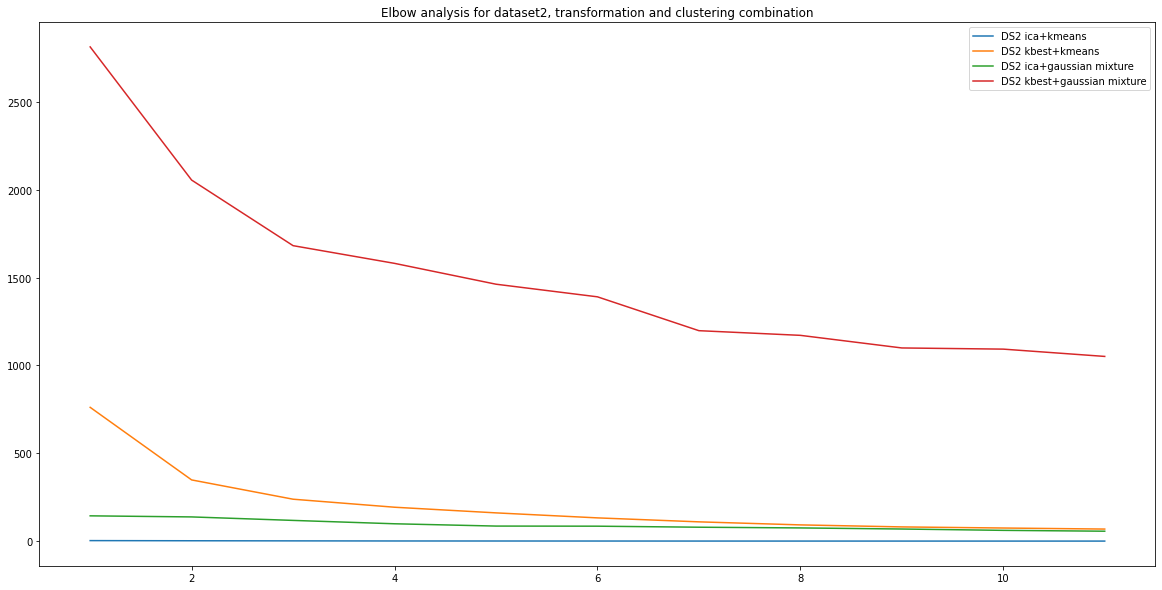

In [85]:
fig = plt.figure(figsize=(20,10))

plt.title('Elbow analysis for dataset2, transformation and clustering combination')
#plt.plot(range(1,12),np.array(K_means1_ssd_pca)/np.max(K_means1_ssd_pca),label='DS1 pca+kmeans')
#plt.plot(range(1,12),np.array(K_means2_ssd_pca),label='DS2 pca+kmeans')

#plt.plot(range(1,12),np.array(K_means1_ssd_ica)/np.max(K_means1_ssd_ica),label='DS1 ica+kmeans')
plt.plot(range(1,12),np.array(K_means2_ssd_ica),label='DS2 ica+kmeans')

#plt.plot(range(1,12),np.array(K_means1_ssd_rca)/np.max(K_means1_ssd_rca),label='DS1 rca+kmeans')
#plt.plot(range(1,12),np.array(K_means2_ssd_rca),label='DS2 rca+kmeans')

#plt.plot(range(1,12),np.array(K_means1_ssd_kbest)/np.max(K_means1_ssd_kbest),label='DS1 kbest+kmeans')
plt.plot(range(1,12),np.array(K_means2_ssd_kbest),label='DS2 kbest+kmeans')

#plt.plot(range(1,12),np.array(GM1_ssd_pca)/np.max(GM1_ssd_pca),label='DS1 pca+gaussian mixture')
#plt.plot(range(1,12),np.array(GM2_ssd_pca),label='DS2 pca+gaussian mixture')

#plt.plot(range(1,12),np.array(GM1_ssd_ica)/np.max(GM1_ssd_ica),label='DS1 ica+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_ica),label='DS2 ica+gaussian mixture')

#plt.plot(range(1,12),np.array(GM1_ssd_rca)/np.max(GM1_ssd_rca),label='DS1 rca+gaussian mixture')
#plt.plot(range(1,12),np.array(GM2_ssd_rca),label='DS2 rca+gaussian mixture')

#plt.plot(range(1,12),np.array(GM1_ssd_kbest)/np.max(GM1_ssd_kbest),label='DS1 kbest+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_kbest),label='DS2 kbest+gaussian mixture')

plt.legend()
plt.show()

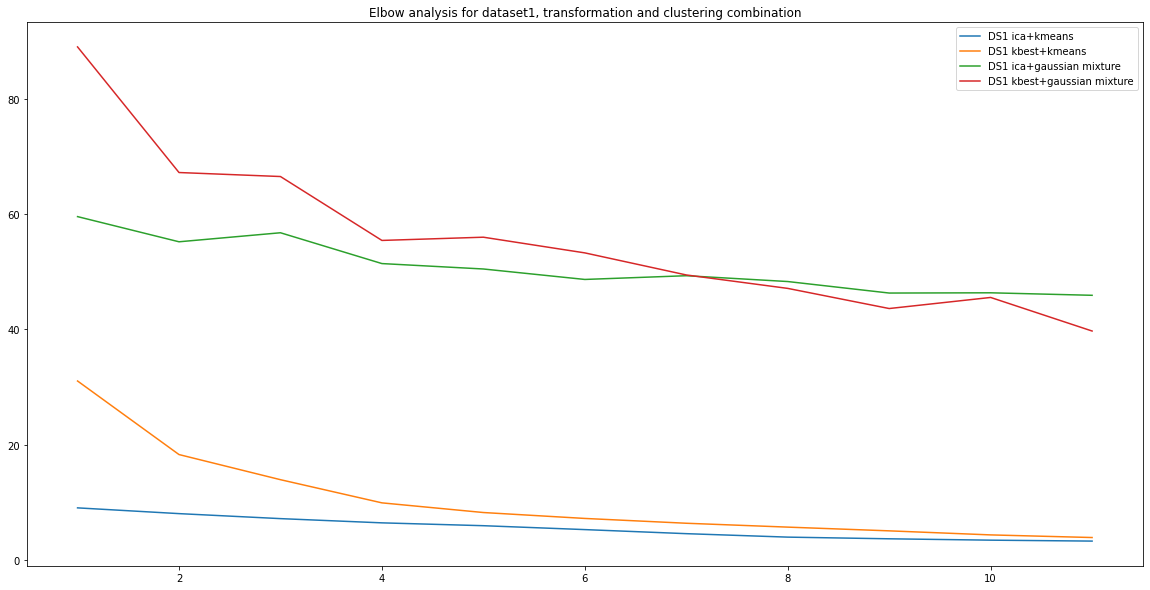

In [75]:
fig = plt.figure(figsize=(20,10))

plt.title('Elbow analysis for dataset1, transformation and clustering combination')
#plt.plot(range(1,12),np.array(K_means1_ssd_pca),label='DS1 pca+kmeans')
#plt.plot(range(1,12),np.array(K_means2_ssd_pca)/np.max(K_means2_ssd_pca),label='DS2 pca+kmeans')

plt.plot(range(1,12),np.array(K_means1_ssd_ica),label='DS1 ica+kmeans')
#plt.plot(range(1,12),np.array(K_means2_ssd_ica)/np.max(K_means2_ssd_ica),label='DS2 ica+kmeans')

#plt.plot(range(1,12),np.array(K_means1_ssd_rca),label='DS1 rca+kmeans')
#plt.plot(range(1,12),np.array(K_means1_ssd_rca)/np.max(K_means1_ssd_rca),label='DS2 rca+kmeans')

plt.plot(range(1,12),np.array(K_means1_ssd_kbest),label='DS1 kbest+kmeans')
#plt.plot(range(1,12),np.array(K_means1_ssd_kbest)/np.max(K_means1_ssd_kbest),label='DS2 kbest+kmeans')

#plt.plot(range(1,12),np.array(GM1_ssd_pca),label='DS1 pca+gaussian mixture')
#plt.plot(range(1,12),np.array(GM2_ssd_pca)/np.max(GM2_ssd_pca),label='DS2 pca+gaussian mixture')

plt.plot(range(1,12),np.array(GM1_ssd_ica),label='DS1 ica+gaussian mixture')
#plt.plot(range(1,12),np.array(GM2_ssd_ica)/np.max(GM2_ssd_ica),label='DS2 ica+gaussian mixture')

#plt.plot(range(1,12),np.array(GM1_ssd_rca),label='DS1 rca+gaussian mixture')
#plt.plot(range(1,12),np.array(GM2_ssd_rca)/np.max(GM2_ssd_rca),label='DS2 rca+gaussian mixture')

plt.plot(range(1,12),np.array(GM1_ssd_kbest),label='DS1 kbest+gaussian mixture')
#plt.plot(range(1,12),np.array(GM2_ssd_kbest)/np.max(GM2_ssd_kbest),label='DS2 kbest+gaussian mixture')

plt.legend()
plt.show()

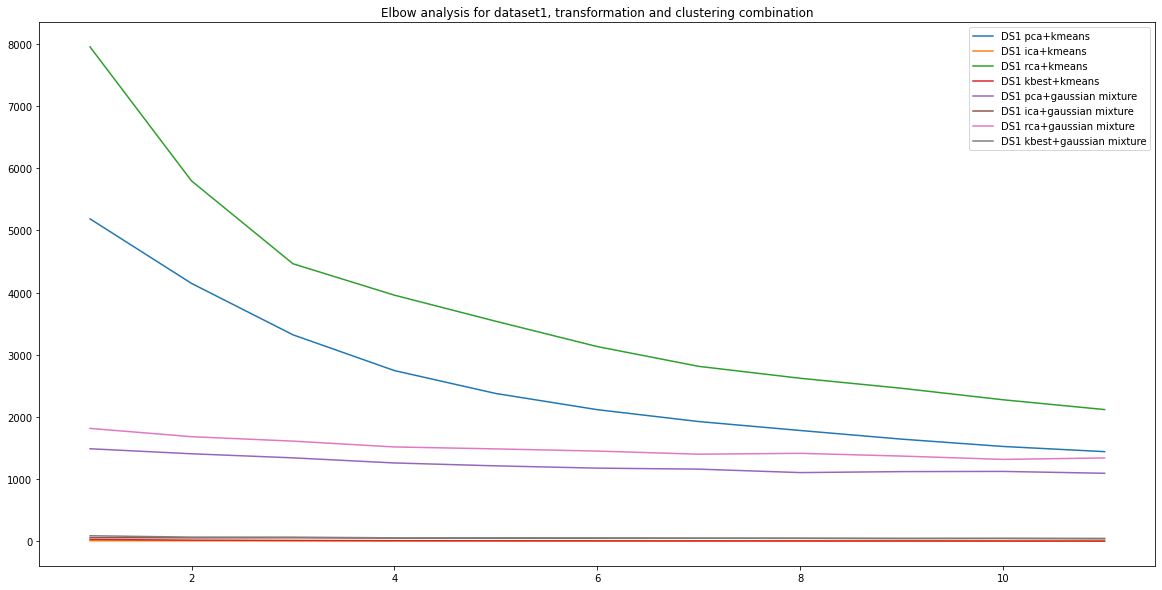

In [73]:
fig = plt.figure(figsize=(20,10))

plt.title('Elbow analysis for dataset1, transformation and clustering combination')
#plt.plot(range(1,12),np.array(K_means1_ssd_pca),label='DS1 pca+kmeans')
#plt.plot(range(1,12),np.array(K_means2_ssd_pca)/np.max(K_means2_ssd_pca),label='DS2 pca+kmeans')

plt.plot(range(1,12),np.array(K_means1_ssd_ica),label='DS1 ica+kmeans')
#plt.plot(range(1,12),np.array(K_means2_ssd_ica)/np.max(K_means2_ssd_ica),label='DS2 ica+kmeans')

#plt.plot(range(1,12),np.array(K_means1_ssd_rca),label='DS1 rca+kmeans')
#plt.plot(range(1,12),np.array(K_means1_ssd_rca)/np.max(K_means1_ssd_rca),label='DS2 rca+kmeans')

plt.plot(range(1,12),np.array(K_means1_ssd_kbest),label='DS1 kbest+kmeans')
#plt.plot(range(1,12),np.array(K_means1_ssd_kbest)/np.max(K_means1_ssd_kbest),label='DS2 kbest+kmeans')

plt.plot(range(1,12),np.array(GM1_ssd_pca),label='DS1 pca+gaussian mixture')
#plt.plot(range(1,12),np.array(GM2_ssd_pca)/np.max(GM2_ssd_pca),label='DS2 pca+gaussian mixture')

plt.plot(range(1,12),np.array(GM1_ssd_ica),label='DS1 ica+gaussian mixture')
#plt.plot(range(1,12),np.array(GM2_ssd_ica)/np.max(GM2_ssd_ica),label='DS2 ica+gaussian mixture')

plt.plot(range(1,12),np.array(GM1_ssd_rca),label='DS1 rca+gaussian mixture')
#plt.plot(range(1,12),np.array(GM2_ssd_rca)/np.max(GM2_ssd_rca),label='DS2 rca+gaussian mixture')

plt.plot(range(1,12),np.array(GM1_ssd_kbest),label='DS1 kbest+gaussian mixture')
#plt.plot(range(1,12),np.array(GM2_ssd_kbest)/np.max(GM2_ssd_kbest),label='DS2 kbest+gaussian mixture')

plt.legend()
plt.show()

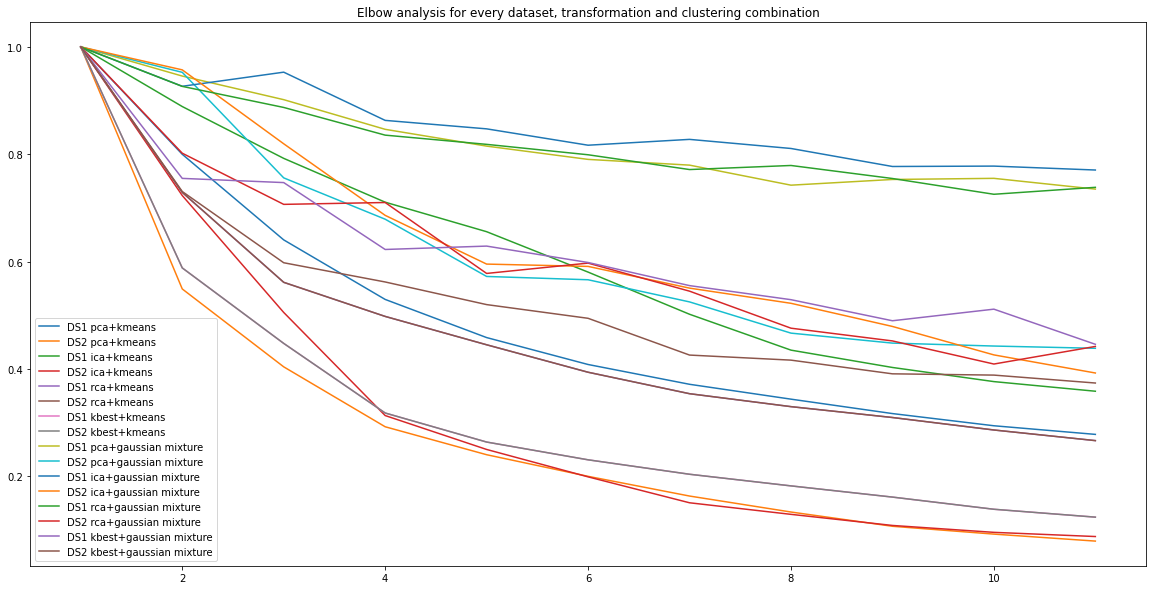

In [70]:
fig = plt.figure(figsize=(20,10))

plt.title('Elbow analysis for every dataset, transformation and clustering combination')
plt.plot(range(1,12),np.array(K_means1_ssd_pca)/np.max(K_means1_ssd_pca),label='DS1 pca+kmeans')
plt.plot(range(1,12),np.array(K_means2_ssd_pca)/np.max(K_means2_ssd_pca),label='DS2 pca+kmeans')

plt.plot(range(1,12),np.array(K_means1_ssd_ica)/np.max(K_means1_ssd_ica),label='DS1 ica+kmeans')
plt.plot(range(1,12),np.array(K_means2_ssd_ica)/np.max(K_means2_ssd_ica),label='DS2 ica+kmeans')

plt.plot(range(1,12),np.array(K_means1_ssd_rca)/np.max(K_means1_ssd_rca),label='DS1 rca+kmeans')
plt.plot(range(1,12),np.array(K_means1_ssd_rca)/np.max(K_means1_ssd_rca),label='DS2 rca+kmeans')

plt.plot(range(1,12),np.array(K_means1_ssd_kbest)/np.max(K_means1_ssd_kbest),label='DS1 kbest+kmeans')
plt.plot(range(1,12),np.array(K_means1_ssd_kbest)/np.max(K_means1_ssd_kbest),label='DS2 kbest+kmeans')

plt.plot(range(1,12),np.array(GM1_ssd_pca)/np.max(GM1_ssd_pca),label='DS1 pca+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_pca)/np.max(GM2_ssd_pca),label='DS2 pca+gaussian mixture')

plt.plot(range(1,12),np.array(GM1_ssd_ica)/np.max(GM1_ssd_ica),label='DS1 ica+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_ica)/np.max(GM2_ssd_ica),label='DS2 ica+gaussian mixture')

plt.plot(range(1,12),np.array(GM1_ssd_rca)/np.max(GM1_ssd_rca),label='DS1 rca+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_rca)/np.max(GM2_ssd_rca),label='DS2 rca+gaussian mixture')

plt.plot(range(1,12),np.array(GM1_ssd_kbest)/np.max(GM1_ssd_kbest),label='DS1 kbest+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_kbest)/np.max(GM2_ssd_kbest),label='DS2 kbest+gaussian mixture')

plt.legend()
plt.show()

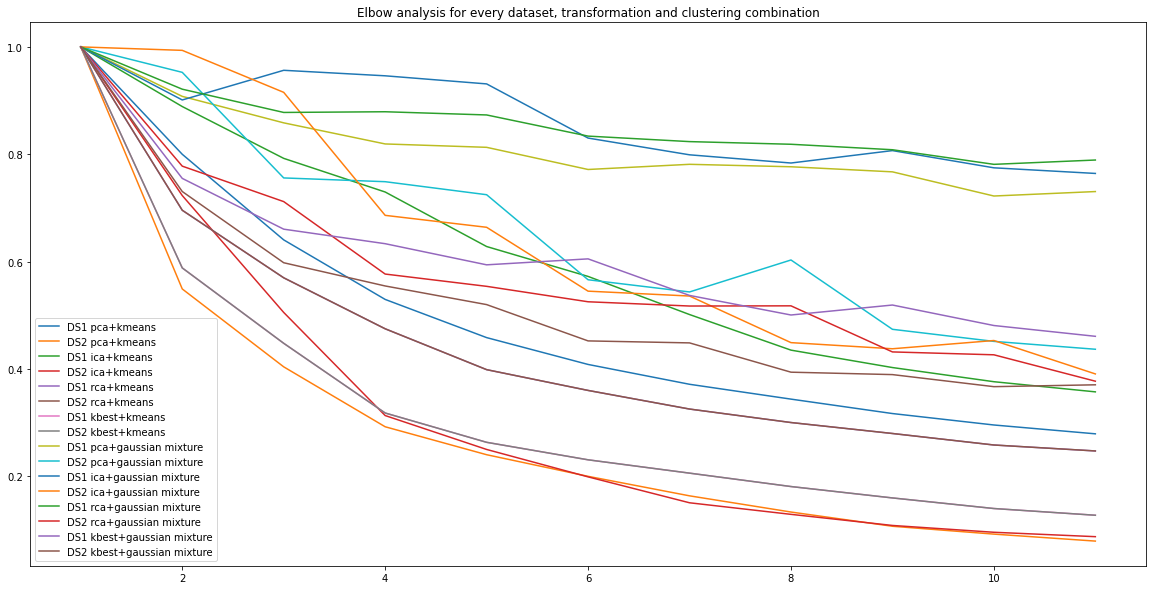

In [81]:
fig = plt.figure(figsize=(20,10))

plt.title('Elbow analysis for every dataset, transformation and clustering combination')
plt.plot(range(1,12),np.array(K_means1_ssd_pca)/np.max(K_means1_ssd_pca),label='DS1 pca+kmeans')
plt.plot(range(1,12),np.array(K_means2_ssd_pca)/np.max(K_means2_ssd_pca),label='DS2 pca+kmeans')

plt.plot(range(1,12),np.array(K_means1_ssd_ica)/np.max(K_means1_ssd_ica),label='DS1 ica+kmeans')
plt.plot(range(1,12),np.array(K_means2_ssd_ica)/np.max(K_means2_ssd_ica),label='DS2 ica+kmeans')

plt.plot(range(1,12),np.array(K_means1_ssd_rca)/np.max(K_means1_ssd_rca),label='DS1 rca+kmeans')
plt.plot(range(1,12),np.array(K_means1_ssd_rca)/np.max(K_means1_ssd_rca),label='DS2 rca+kmeans')

plt.plot(range(1,12),np.array(K_means1_ssd_kbest)/np.max(K_means1_ssd_kbest),label='DS1 kbest+kmeans')
plt.plot(range(1,12),np.array(K_means1_ssd_kbest)/np.max(K_means1_ssd_kbest),label='DS2 kbest+kmeans')

plt.plot(range(1,12),np.array(GM1_ssd_pca)/np.max(GM1_ssd_pca),label='DS1 pca+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_pca)/np.max(GM2_ssd_pca),label='DS2 pca+gaussian mixture')

plt.plot(range(1,12),np.array(GM1_ssd_ica)/np.max(GM1_ssd_ica),label='DS1 ica+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_ica)/np.max(GM2_ssd_ica),label='DS2 ica+gaussian mixture')

plt.plot(range(1,12),np.array(GM1_ssd_rca)/np.max(GM1_ssd_rca),label='DS1 rca+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_rca)/np.max(GM2_ssd_rca),label='DS2 rca+gaussian mixture')

plt.plot(range(1,12),np.array(GM1_ssd_kbest)/np.max(GM1_ssd_kbest),label='DS1 kbest+gaussian mixture')
plt.plot(range(1,12),np.array(GM2_ssd_kbest)/np.max(GM2_ssd_kbest),label='DS2 kbest+gaussian mixture')

plt.legend()
plt.show()

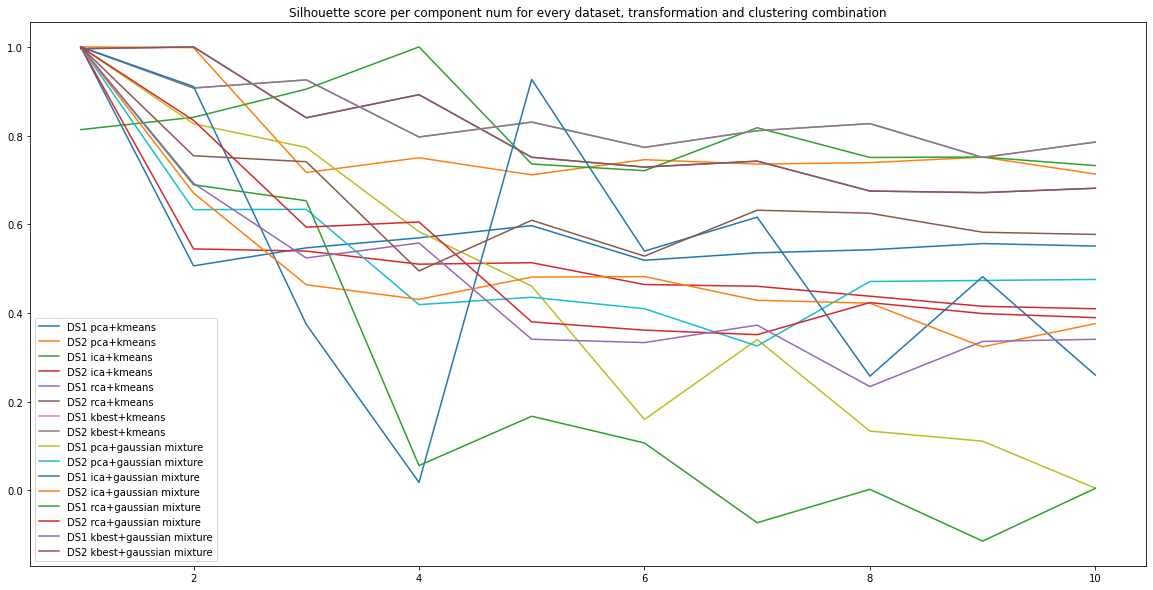

In [84]:
fig = plt.figure(figsize=(20,10))

plt.title('Silhouette score per component num for every dataset, transformation and clustering combination')
plt.plot(range(1,11),np.array(K_means1_sil_pca)/np.max(K_means1_sil_pca),label='DS1 pca+kmeans')
plt.plot(range(1,11),np.array(K_means2_sil_pca)/np.max(K_means2_sil_pca),label='DS2 pca+kmeans')

plt.plot(range(1,11),np.array(K_means1_sil_ica)/np.max(K_means1_sil_ica),label='DS1 ica+kmeans')
plt.plot(range(1,11),np.array(K_means2_sil_ica)/np.max(K_means2_sil_ica),label='DS2 ica+kmeans')

plt.plot(range(1,11),np.array(K_means1_sil_rca)/np.max(K_means1_sil_rca),label='DS1 rca+kmeans')
plt.plot(range(1,11),np.array(K_means1_sil_rca)/np.max(K_means1_sil_rca),label='DS2 rca+kmeans')

plt.plot(range(1,11),np.array(K_means1_sil_kbest)/np.max(K_means1_sil_kbest),label='DS1 kbest+kmeans')
plt.plot(range(1,11),np.array(K_means1_sil_kbest)/np.max(K_means1_sil_kbest),label='DS2 kbest+kmeans')

plt.plot(range(1,11),np.array(GM1_sil_pca)/np.max(GM1_sil_pca),label='DS1 pca+gaussian mixture')
plt.plot(range(1,11),np.array(GM2_sil_pca)/np.max(GM2_sil_pca),label='DS2 pca+gaussian mixture')

plt.plot(range(1,11),np.array(GM1_sil_ica)/np.max(GM1_sil_ica),label='DS1 ica+gaussian mixture')
plt.plot(range(1,11),np.array(GM2_sil_ica)/np.max(GM2_sil_ica),label='DS2 ica+gaussian mixture')

plt.plot(range(1,11),np.array(GM1_sil_rca)/np.max(GM1_sil_rca),label='DS1 rca+gaussian mixture')
plt.plot(range(1,11),np.array(GM2_sil_rca)/np.max(GM2_sil_rca),label='DS2 rca+gaussian mixture')

plt.plot(range(1,11),np.array(GM1_sil_kbest)/np.max(GM1_sil_kbest),label='DS1 kbest+gaussian mixture')
plt.plot(range(1,11),np.array(GM2_sil_kbest)/np.max(GM2_sil_kbest),label='DS2 kbest+gaussian mixture')

plt.legend()
plt.show()

## Neural network on transformed features

In [217]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)
X1_train_pos, X1_test_pos, y1_train_pos, y1_test_pos = train_test_split(X1_pos, y1, test_size=0.2)

## without dim red (assignment 1)

F1 train score:0.99
F1 test score:0.42
runtime:11.95 seconds


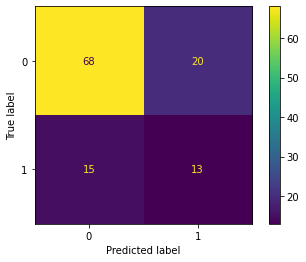

In [171]:
start = time.time()

x_train = X1_train
x_test = X1_test

k = 50
ANN = MLPClassifier((k,k,k),'relu',learning_rate_init=0.01)
ANN.fit(np.repeat(x_train,10,axis=0),np.repeat(y1_train,10))

nn_time = time.time() - start

y_pred = ANN.predict(x_test)
train_pred =  ANN.predict(x_train)
train_f1_pca = f1_score(train_pred,y1_train)
test_f1_pca = f1_score(y_pred,y1_test)
    
plot_confusion_matrix(ANN,x_test,y1_test.reshape(-1,1))
print('F1 train score:%s\nF1 test score:%s\nruntime:%s seconds'%(int(100*train_f1_pca)/100,int(100*test_f1_pca)/100,int(100*pca_nn_time)/100))

# ANN training with PCA

F1 train score:0.98
F1 test score:0.42
runtime:3.81 seconds


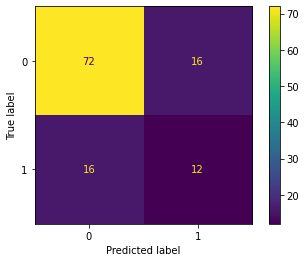

In [173]:
start = time.time()

pca1 = PCA(6)
x_train = pca1.fit_transform(X1_train)
x_test = pca1.transform(X1_test)

k = 50
ANN = MLPClassifier((k,k,k),'relu',learning_rate_init=0.01)
ANN.fit(np.repeat(x_train,10,axis=0),np.repeat(y1_train,10))

pca_nn_time = time.time() - start

y_pred = ANN.predict(x_test)
train_pred =  ANN.predict(x_train)
train_f1_pca = f1_score(train_pred,y1_train)
test_f1_pca = f1_score(y_pred,y1_test)
    
plot_confusion_matrix(ANN,x_test,y1_test.reshape(-1,1))
print('F1 train score:%s\nF1 test score:%s\nruntime:%s seconds'%(int(100*train_f1_pca)/100,int(100*test_f1_pca)/100,int(100*pca_nn_time)/100))

100%|██████████| 6/6 [00:35<00:00,  5.87s/it]


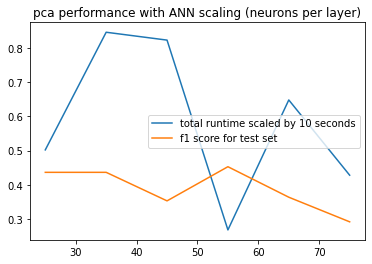

In [192]:
#time saved evolution with scales of the neural network 


time_pca_neurons = []
pca_neuron_fscore = []
for k in tqdm.tqdm(range(50,160,20)):
    start = time.time()
    pca1 = PCA(6)
    x_train = pca1.fit_transform(X1_train)
    x_test = pca1.transform(X1_test)

    ANN = MLPClassifier((k,k),'relu',learning_rate_init=0.01)
    ANN.fit(np.repeat(x_train,10,axis=0),np.repeat(y1_train,10))

    time_pca_neurons.append(int(100*(time.time() - start))/1000)

    y_pred = ANN.predict(x_test)
    pca_neuron_fscore.append(f1_score(y_pred,y1_test))
    
fig = plt.figure()
plt.title('pca performance with ANN scaling (neurons per layer)')
plt.plot(range(25,85,10),time_pca_neurons,label='total runtime scaled by 10 seconds')
plt.plot(range(25,85,10),pca_neuron_fscore,label='f1 score for test set')
plt.legend()
plt.show()

100%|██████████| 6/6 [00:26<00:00,  4.47s/it]


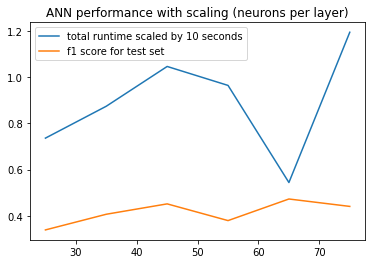

In [194]:

time_neurons = []
neuron_fscore = []
for k in tqdm.tqdm(range(50,160,20)):
    start = time.time()
    x_train = X1_train
    x_test = X1_test

    ANN = MLPClassifier((k,k),'relu',learning_rate_init=0.01)
    ANN.fit(np.repeat(x_train,10,axis=0),np.repeat(y1_train,10))

    time_neurons.append(int(100*(time.time() - start))/1000)

    y_pred = ANN.predict(x_test)
    neuron_fscore.append(f1_score(y_pred,y1_test))
    
fig = plt.figure()
plt.title('ANN performance with scaling (neurons per layer)')
plt.plot(range(25,85,10),time_neurons,label='total runtime scaled by 10 seconds')
plt.plot(range(25,85,10),neuron_fscore,label='f1 score for test set')
plt.legend()
plt.show()

## ANN with ICA

/home/aymane/.local/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


F1 train score:0.95
F1 test score:0.43
runtime:6.59 seconds


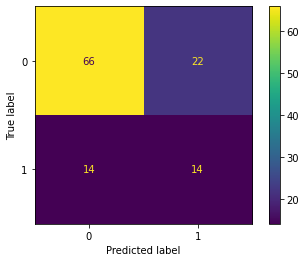

In [174]:
start = time.time()

ica1 = ICA(9)
x_train = ica1.fit_transform(X1_train)
x_test = ica1.transform(X1_test)

k = 50
ANN = MLPClassifier((k,k,k),'relu',learning_rate_init=0.01)
ANN.fit(np.repeat(x_train,10,axis=0),np.repeat(y1_train,10))

ica_nn_time = time.time() - start

y_pred = ANN.predict(x_test)
train_pred =  ANN.predict(x_train)
train_f1_ica = f1_score(train_pred,y1_train)
test_f1_ica = f1_score(y_pred,y1_test)
    
plot_confusion_matrix(ANN,x_test,y1_test.reshape(-1,1))
print('F1 train score:%s\nF1 test score:%s\nruntime:%s seconds'%(int(100*train_f1_ica)/100,int(100*test_f1_ica)/100,int(100*ica_nn_time)/100))

## ANN with randomized projections

F1 train score:0.97
F1 test score:0.53
runtime:3.06 seconds


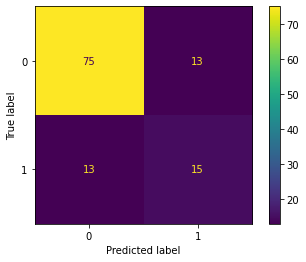

In [176]:
start = time.time()

rca1 = RCA(6)
x_train = rca1.fit_transform(X1_train)
x_test = rca1.transform(X1_test)

k = 50
ANN = MLPClassifier((k,k,k),'relu',learning_rate_init=0.01)
ANN.fit(np.repeat(x_train,10,axis=0),np.repeat(y1_train,10))

rca_nn_time = time.time() - start

y_pred = ANN.predict(x_test)
train_pred =  ANN.predict(x_train)
train_f1_rca = f1_score(train_pred,y1_train)
test_f1_rca = f1_score(y_pred,y1_test)
    
plot_confusion_matrix(ANN,x_test,y1_test.reshape(-1,1))
print('F1 train score:%s\nF1 test score:%s\nruntime:%s seconds'%(int(100*train_f1_rca)/100,int(100*test_f1_rca)/100,int(100*rca_nn_time)/100))

## ANN with kbest

F1 train score:0.44
F1 test score:0.48
runtime:5.82 seconds


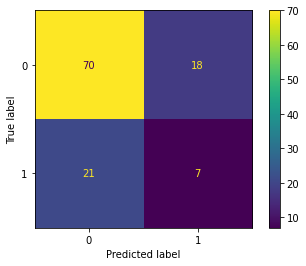

In [143]:
start = time.time()

kbest1 = Kbest(chi2, k=7)
x_train = kbest1.fit_transform(X1_train_pos, y1_train_pos)
x_test = kbest1.transform(X1_test_pos)

k = 50
ANN = MLPClassifier((k,k,k),'logistic',learning_rate_init=0.01)
ANN.fit(np.repeat(x_train,10,axis=0),np.repeat(y1_train_pos,10))

kbest_nn_time = time.time() - start

y_pred = ANN.predict(x_test)
train_pred =  ANN.predict(x_train)
train_f1_kbest = f1_score(train_pred,y1_train_pos)
test_f1_kbest = f1_score(y_pred,y1_test_pos)
    
plot_confusion_matrix(ANN,x_test,y1_test.reshape(-1,1))
print('F1 train score:%s\nF1 test score:%s\nruntime:%s seconds'%(int(100*train_f1_kbest)/100,int(100*test_f1_kbest)/100,int(100*kbest_nn_time)/100))

## ANN with K_means, clusters as features

F1 train score:0.0
F1 test score:0.0
runtime:8.16 seconds


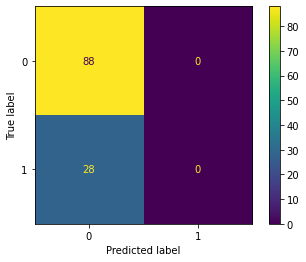

In [213]:
start = time.time()

km1 = KMeans(n_clusters=10)
x_train = km1.fit_predict(X1_train).reshape(-1,1)
x_test = km1.predict(X1_test).reshape(-1,1)

k = 50
ANN = MLPClassifier((k,k),'relu',learning_rate_init=0.01)
ANN.fit(np.repeat(x_train,10,axis=0),np.repeat(y1_train,10))

kmeansnn_time = time.time() - start

y_pred = ANN.predict(x_test)
train_pred =  ANN.predict(x_train)
train_f1_kbest = f1_score(train_pred,y1_train)
test_f1_kbest = f1_score(y_pred,y1_test)
    
plot_confusion_matrix(ANN,x_test,y1_test.reshape(-1,1))
print('F1 train score:%s\nF1 test score:%s\nruntime:%s seconds'%(int(100*train_f1_kbest)/100,int(100*test_f1_kbest)/100,int(100*kbest_nn_time)/100))

## ANN with Gaussian Mixtrues, clusters as features

F1 train score:0.0
F1 test score:0.0
runtime:8.16 seconds


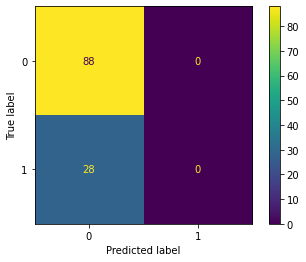

In [216]:
start = time.time()

km1 = GaussianMixture(n_components=15)
x_train = km1.fit_predict(X1_train).reshape(-1,1)
x_test = km1.predict(X1_test).reshape(-1,1)

k = 50
ANN = MLPClassifier((k,k),'relu',learning_rate_init=0.01)
ANN.fit(np.repeat(x_train,10,axis=0),np.repeat(y1_train,10))

kmeansnn_time = time.time() - start

y_pred = ANN.predict(x_test)
train_pred =  ANN.predict(x_train)
train_f1_kbest = f1_score(train_pred,y1_train)
test_f1_kbest = f1_score(y_pred,y1_test)
    
plot_confusion_matrix(ANN,x_test,y1_test.reshape(-1,1))
print('F1 train score:%s\nF1 test score:%s\nruntime:%s seconds'%(int(100*train_f1_kbest)/100,int(100*test_f1_kbest)/100,int(100*kbest_nn_time)/100))

F1 train score:0.28
F1 test score:0.3
runtime:8.16 seconds


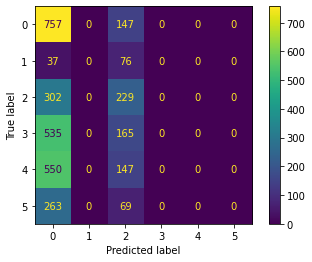

In [221]:
start = time.time()

km1 = KMeans(n_clusters=15)
x_train = km1.fit_predict(X2_train).reshape(-1,1)
x_test = km1.predict(X2_test).reshape(-1,1)

k = 50
ANN = MLPClassifier((k,k),'relu',learning_rate_init=0.01)
ANN.fit(np.repeat(x_train,10,axis=0),np.repeat(y2_train,10))

kmeansnn_time = time.time() - start

y_pred = ANN.predict(x_test)
train_pred =  ANN.predict(x_train)
train_f1_kbest = accuracy_score(train_pred,y2_train)
test_f1_kbest = accuracy_score(y_pred,y2_test)
    
plot_confusion_matrix(ANN,x_test,y2_test.reshape(-1,1))
print('F1 train score:%s\nF1 test score:%s\nruntime:%s seconds'%(int(100*train_f1_kbest)/100,int(100*test_f1_kbest)/100,int(100*kbest_nn_time)/100))

F1 train score:0.28
F1 test score:0.27
runtime:8.16 seconds


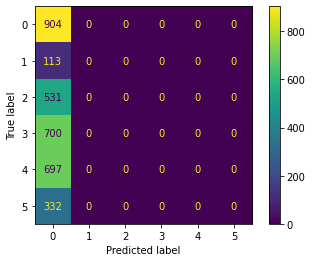

In [222]:
start = time.time()

km1 = KMeans(n_clusters=6)
x_train = km1.fit_predict(X2_train).reshape(-1,1)
x_test = km1.predict(X2_test).reshape(-1,1)

k = 50
ANN = MLPClassifier((k,k),'relu',learning_rate_init=0.01)
ANN.fit(np.repeat(x_train,10,axis=0),np.repeat(y2_train,10))

kmeansnn_time = time.time() - start

y_pred = ANN.predict(x_test)
train_pred =  ANN.predict(x_train)
train_f1_kbest = accuracy_score(train_pred,y2_train)
test_f1_kbest = accuracy_score(y_pred,y2_test)
    
plot_confusion_matrix(ANN,x_test,y2_test.reshape(-1,1))
print('F1 train score:%s\nF1 test score:%s\nruntime:%s seconds'%(int(100*train_f1_kbest)/100,int(100*test_f1_kbest)/100,int(100*kbest_nn_time)/100))

F1 train score:0.31
F1 test score:0.32
runtime:8.16 seconds


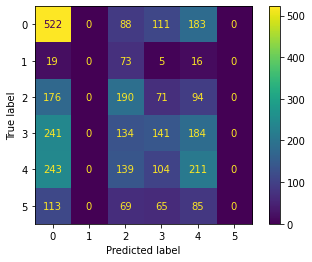

In [223]:
start = time.time()

km1 = KMeans(n_clusters=20)
x_train = km1.fit_predict(X2_train).reshape(-1,1)
x_test = km1.predict(X2_test).reshape(-1,1)

k = 50
ANN = MLPClassifier((k,k),'relu',learning_rate_init=0.01)
ANN.fit(np.repeat(x_train,10,axis=0),np.repeat(y2_train,10))

kmeansnn_time = time.time() - start

y_pred = ANN.predict(x_test)
train_pred =  ANN.predict(x_train)
train_f1_kbest = accuracy_score(train_pred,y2_train)
test_f1_kbest = accuracy_score(y_pred,y2_test)
    
plot_confusion_matrix(ANN,x_test,y2_test.reshape(-1,1))
print('F1 train score:%s\nF1 test score:%s\nruntime:%s seconds'%(int(100*train_f1_kbest)/100,int(100*test_f1_kbest)/100,int(100*kbest_nn_time)/100))

/home/aymane/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


F1 train score:0.34
F1 test score:0.35
runtime:8.16 seconds


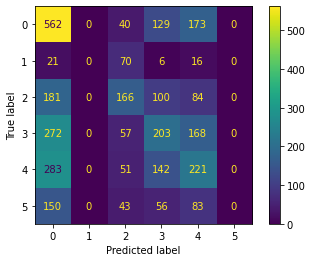

In [224]:
start = time.time()

km1 = KMeans(n_clusters=25)
x_train = km1.fit_predict(X2_train).reshape(-1,1)
x_test = km1.predict(X2_test).reshape(-1,1)

k = 50
ANN = MLPClassifier((k,k),'relu',learning_rate_init=0.01)
ANN.fit(np.repeat(x_train,10,axis=0),np.repeat(y2_train,10))

kmeansnn_time = time.time() - start

y_pred = ANN.predict(x_test)
train_pred =  ANN.predict(x_train)
train_f1_kbest = accuracy_score(train_pred,y2_train)
test_f1_kbest = accuracy_score(y_pred,y2_test)
    
plot_confusion_matrix(ANN,x_test,y2_test.reshape(-1,1))
print('F1 train score:%s\nF1 test score:%s\nruntime:%s seconds'%(int(100*train_f1_kbest)/100,int(100*test_f1_kbest)/100,int(100*kbest_nn_time)/100))